# Build SARIMA model
parameter: p, d, q, P, D, Q, M

In [ ]:
!pip install -q kaggle
!pip install -q statsmodels -U

In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content/'

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set

Dataset URL: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
License(s): DbCL-1.0
electric-power-consumption-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip electric-power-consumption-data-set.zip

Archive:  electric-power-consumption-data-set.zip
  inflating: household_power_consumption.txt  


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Section 0: Data preparation

In [ ]:
df = pd.read_csv("household_power_consumption.txt", sep=';')

/tmp/ipython-input-2744125585.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("household_power_consumption.txt", sep=';')


In [ ]:
df['datetime'] = df["Date"] + " " + df["Time"]
df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
df.drop(["Date", "Time"], axis=1, inplace=True)
df.set_index("datetime", inplace=True)

/tmp/ipython-input-4108112490.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
/tmp/ipython-input-4108112490.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)


In [19]:
cate_cols = df.select_dtypes(include="object").columns
df[cate_cols] = df[cate_cols].apply(pd.to_numeric, errors='coerce')

for col in cate_cols:
  df[col] = df[col].fillna(df[col].mean())

In [21]:
weekly_data = df.resample("W").sum()

# Create Model

In [23]:
p, d, q = 1, 1, 0
P, D, Q, M = 1,1,0,52 # 1 year = 52 week
order = (p,d,q)
seasonal_order = (P,D,Q,M)

In [25]:
sarima_model = SARIMAX(weekly_data["Global_active_power"], order=order, seasonal_order=seasonal_order).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                  207
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1420.371
Date:                            Sun, 01 Feb 2026   AIC                           2846.742
Time:                                    07:41:31   BIC                           2855.853
Sample:                                12-17-2006   HQIC                          2850.443
                                     - 11-28-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3270      0.061     -5.338      0.000      -0.447      -0.207
ar.S.L52      -0.4363      0.039    -11.233      0.000      -0.512      -0.360
sigma2      6.008e+06   4.48e+05     13.398      0.000    5.13e+06    6.89e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                46.32
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.12
Prob(H) (two-sided):                  0.84   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

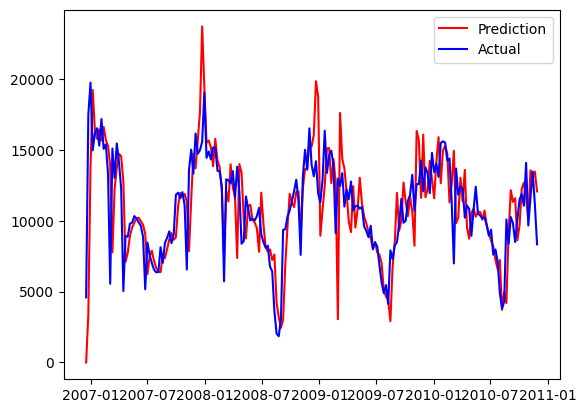

In [27]:
plt.plot(sarima_model.fittedvalues, label='Prediction', color='red')
plt.plot(weekly_data["Global_active_power"], label='Actual', color='blue')
plt.legend()
plt.show()

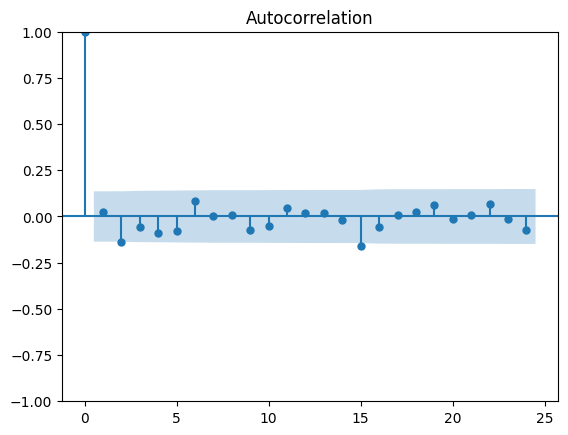

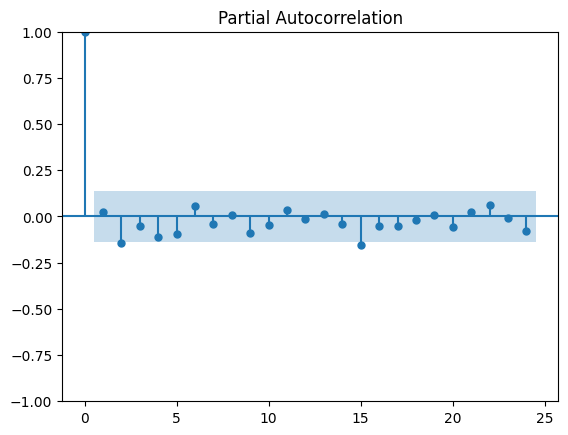

In [29]:
plot_acf(sarima_model.resid)
plt.show()
plot_pacf(sarima_model.resid)
plt.show()

# Future prediction

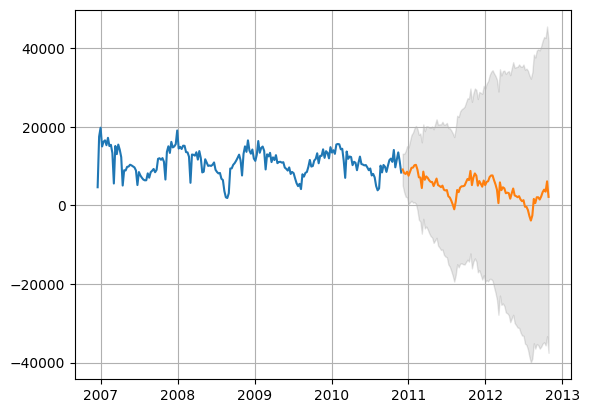

In [32]:
future_fcst = sarima_model.get_forecast(100) # forecast next 100 value

confidence_int = future_fcst.conf_int(alpha=0.1)
fcst = future_fcst.predicted_mean


plt.plot(weekly_data["Global_active_power"])
plt.plot(fcst)
plt.fill_between(confidence_int.index, confidence_int['lower Global_active_power'], confidence_int['upper Global_active_power'], color='k', alpha=0.1)
plt.grid()
plt.show()

# Parameter tuning setup

In [39]:
from tqdm import tqdm_notebook
def validate(series, horizon, start, step_size, order=(1,0,0), seasonal_order=(0,0,0,0)):
  y_pred = []
  y_true = []
  for i in tqdm_notebook(range(start, len(series)-horizon, step_size)):
    model = sm.tsa.statespace.SARIMAX(series[:i+1], order=order, seasonal_order=seasonal_order).fit()
    y_pred.append(model.forecast(horizon)[-1])
    y_true.append(series[i+horizon])
  return np.array(y_pred), np.array(y_true)

In [48]:
def mape(result):
  y_true, y_pred = result
  return abs((y_true - y_pred) / y_true).sum() / len(y_true)

In [37]:
train_series = weekly_data["Global_active_power"][:175]
test_series = weekly_data["Global_active_power"][175:]

In [40]:
# Generate some random parameter values
order = (1,1,0)
seasonal_order = (1,1,0,52)
horizon = 52
start = 104 + 1
step_size = 4
result =validate(train_series, horizon, start, step_size, order, seasonal_order)

/tmp/ipython-input-1390137322.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(start, len(series)-horizon, step_size)):


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

[0.00237533 0.00890934 0.00342642 0.00158039 0.01377058]


/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])


In [49]:
print(mape(result))

0.14276957605757365


In [50]:
def gridSearch(series, horizon ,start, step_size, validate_func, p_range=[], d_range=[],
               q_range=[], m_range=[]):
  best_mape = np.inf
  best_order = None
  best_seasonal_order =None
  for p in p_range:
    for q in q_range:
      for d in d_range:
        for m in m_range:
          order = (p,d,q)
          seasonal_order = (1,1,0,m)
          error = mape(validate_func(series, horizon, start, step_size, order, seasonal_order))
          if error < best_mape:
            best_mape = error
            best_order = order
            best_seasonal_order = seasonal_order
  return best_mape, best_order, best_seasonal_order

In [51]:
horizon = 52
start = 104 + 1
step_size = 4

best_mape, best_order, best_seasonal_order = gridSearch(train_series, horizon, start, step_size, validate, p_range=[1,2,3,4], d_range=[1], q_range=[0,1], m_range=[52])

/tmp/ipython-input-1390137322.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(start, len(series)-horizon, step_size)):


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame be

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(series[i+horizon])
/tmp/ipython-input-1390137322.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(model.forecast(horizon)[-1])
/tmp/ipython-input-1390137322.py:8: FutureWarning: Series.__getitem__ t

In [52]:
print(f'best Params: Order: {order}, Seasonal Order: {seasonal_order}')

best Params: Order: (1, 1, 0), Seasonal Order: (1, 1, 0, 52)


# Test and evaluation

In [53]:
sarima_model = sm.tsa.statespace.SARIMAX(train_series, order=best_order, seasonal_order=best_seasonal_order).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                 Global_active_power   No. Observations:                  175
Model:             SARIMAX(4, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1127.400
Date:                             Sun, 01 Feb 2026   AIC                           2268.800
Time:                                     08:29:16   BIC                           2288.428
Sample:                                 12-17-2006   HQIC                          2276.772
                                      - 04-18-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4647      0.116      4.010      0.000       0.238       0.692
ar.L2          0.1703      0.119      1.429      0.153      -0.063       0.404
ar.L3         -0.0073      0.123     -0.059      0.953      -0.248       0.233
ar.L4         -0.0143      0.135     -0.106      0.916      -0.278       0.250
ma.L1         -0.9388      0.083    -11.277      0.000      -1.102      -0.776
ar.S.L52      -0.4489      0.053     -8.506      0.000      -0.552      -0.345
sigma2      6.723e+06   8.08e+05      8.322      0.000    5.14e+06    8.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                24.13
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.03
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

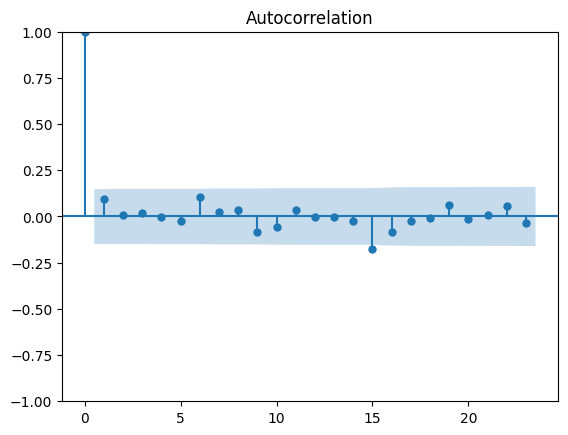

In [55]:
plot_acf(sarima_model.resid)
plt.show()

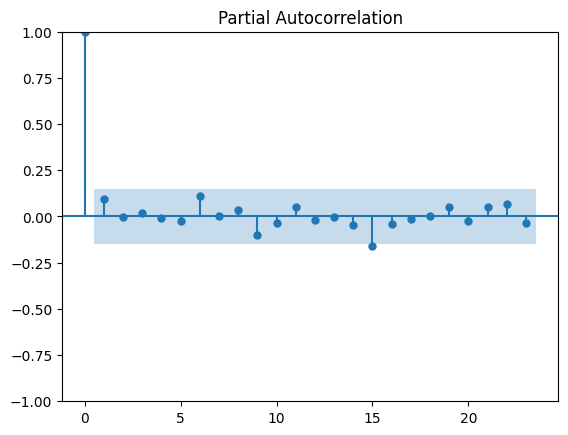

In [56]:
plot_pacf(sarima_model.resid)
plt.show()

In [57]:
y_pred = sarima_model.get_forecast(len(test_series))
test_error = mape((test_series.values, y_pred.predicted_mean))

print(test_error)

0.1430807097430655


In [58]:
confidence_int = y_pred.conf_int(alpha=0.1)

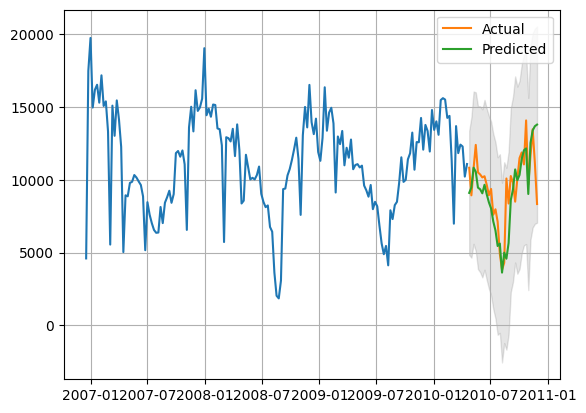

In [59]:
plt.plot(train_series)
plt.plot(test_series, label='Actual')
plt.plot(y_pred.predicted_mean, label='Predicted')
plt.fill_between(confidence_int.index, confidence_int['lower Global_active_power'], confidence_int['upper Global_active_power'], color='k', alpha=0.1)
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Future Forecast

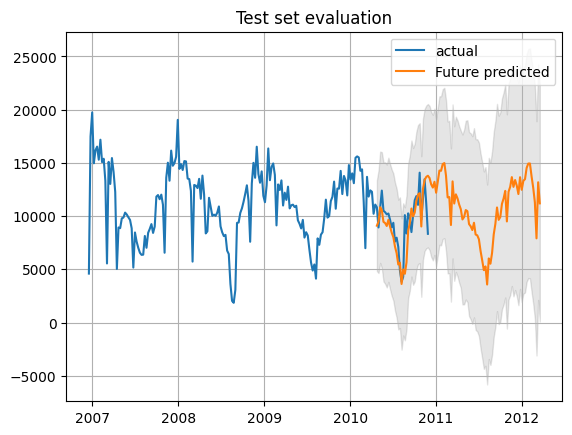

In [61]:
future_forecast = sarima_model.get_forecast(100)
confidence_int = future_forecast.conf_int(alpha=0.1)
fcst = future_forecast.predicted_mean

plt.title("Test set evaluation")
plt.plot(weekly_data["Global_active_power"], label='actual')
plt.plot(fcst, label='Future predicted')
plt.fill_between(confidence_int.index, confidence_int['lower Global_active_power'], confidence_int['upper Global_active_power'], color='k', alpha=0.1)
plt.legend(loc='upper right')
plt.grid()
plt.show()